# Token-level log-probability visualization (Human vs LLM)

This notebook loads token-level data from NPZ files produced by `fingerprinting_llms.score.LogProbs`
and visualizes the first *N* tokens for both the human reference and the LLM output as **separate**
horizontal, color-coded tables. Cell color encodes token log-probability (model confidence).

Key fix: we explicitly **disable Matplotlib's automatic table font scaling** (`auto_set_font_size(False)`)
so both figures use the exact same font size.


In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from fingerprinting_llms.score import LogProbs

# Make plots appear inline in the notebook
%matplotlib inline

In [65]:
# === Parameters ===

START_TOKEN = 140
NUM_TOKENS = 15        # <-- change this to visualize more/less tokens
FONT_SIZE  = 11        # <-- presentation-friendly base font size
CMAP_NAME  = "RdYlGn"  # diverging: low (red/orange) -> high (green)
TABLE_X_SCALE = 1.6  # <-- bump this up if tokens/ranks look cramped

human_path = "data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean/AaronPressman/106247newsML.txt.npz"
llm_path   = "data/tokens/bigmixtral-llama70Bw4a16-graded/reuter5050/C50train_clean/AaronPressman/106247newsML.txt.npz"

# Optional: directory where figures will be saved
output_dir = "eda_outputs/figures"
os.makedirs(output_dir, exist_ok=True)

# Global font size so everything (titles, tick labels, table text) is consistent
plt.rcParams.update({
    "font.size": FONT_SIZE,
})

In [66]:
def make_token_table_figure(
    tokens, ranks, logprobs, title,
    lp_min=None, lp_max=None,
    cmap_name=CMAP_NAME,
    font_size=FONT_SIZE,
    table_x_scale=TABLE_X_SCALE,
):
    """Create a single figure containing a colored token table + colorbar.

    Explicitly disables Matplotlib's automatic font scaling for tables so that
    the requested font size is used identically in every figure.
    """
    tokens = list(tokens)
    ranks = np.array(ranks)
    logprobs = np.array(logprobs, dtype=float)

    # Normalization for color mapping
    if lp_min is None:
        lp_min = logprobs.min()
    if lp_max is None:
        lp_max = logprobs.max()

    if np.isclose(lp_min, lp_max):
        norm_vals = np.full_like(logprobs, 0.5, dtype=float)
    else:
        norm_vals = (logprobs - lp_min) / (lp_max - lp_min)

    cmap = plt.cm.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=lp_min, vmax=lp_max)

    # Figure: wide but not tall
    fig_width = max(8, 0.7 * len(tokens) * table_x_scale)
    fig_height = 3.0
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis("off")

    # Table data: 3 rows — token, rank, log p
    table_data = [
        tokens,
        [str(rk) for rk in ranks],
        [f"{lp:.2f}" for lp in logprobs],
    ]
    row_labels = ["Token", "rank", "log p"]

    table = ax.table(
        cellText=table_data,
        rowLabels=row_labels,
        loc="center",
        cellLoc="center",
    )

    # Critical: turn OFF auto font scaling
    table.auto_set_font_size(False)

    # Scale cells: x controls column width, y controls row height
    table.scale(table_x_scale, 1.6)

    # Apply consistent font size to ALL cells (row labels + contents)
    for (row, col), cell in table.get_celld().items():
        cell.get_text().set_fontsize(font_size)

    # Color the token, rank, and log p cells per column based on normalized log-prob
    n_rows = len(table_data)
    for j, v in enumerate(norm_vals):
        color = cmap(v)
        for i in range(n_rows):
            cell = table[(i, j)]
            cell.set_facecolor(color)
            # Choose text color based on background luminance for readability
            r, g, b, _ = color
            luminance = 0.299 * r + 0.587 * g + 0.114 * b
            text_color = "black" if luminance > 0.6 else "white"
            cell.get_text().set_color(text_color)

    ax.set_title(title, pad=6, fontsize=font_size + 2)

    # Tight layout to pack the table
    fig.tight_layout(pad=0.5)

    # Add colorbar below the table (in figure coordinates)
    # [left, bottom, width, height]
    cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.08])
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Token log-probability (higher = greener)", fontsize=font_size)

    return fig, ax

In [67]:
# Load human and LLM logprob data
human_logprobs = LogProbs.from_file(human_path)
llm_logprobs   = LogProbs.from_file(llm_path)

# Slice to the first NUM_TOKENS tokens
h_tokens   = human_logprobs.decoded_tokens[START_TOKEN:START_TOKEN+NUM_TOKENS]
h_ranks    = human_logprobs.token_ranks[START_TOKEN:START_TOKEN+NUM_TOKENS]
h_logprobs = human_logprobs.token_probs[START_TOKEN:START_TOKEN+NUM_TOKENS]  # assuming these are log-probs

l_tokens   = llm_logprobs.decoded_tokens[START_TOKEN:START_TOKEN+NUM_TOKENS]
l_ranks    = llm_logprobs.token_ranks[START_TOKEN:START_TOKEN+NUM_TOKENS]
l_logprobs = llm_logprobs.token_probs[START_TOKEN:START_TOKEN+NUM_TOKENS]    # assuming these are log-probs

# Construct dataframes for inspection
df_human = pd.DataFrame({
    "Human Decoded Tokens": h_tokens,
    "Human Token Ranks":    h_ranks,
    "Human Token Log Probs": h_logprobs,
})

df_llm = pd.DataFrame({
    "LLM Decoded Tokens": l_tokens,
    "LLM Token Ranks":    l_ranks,
    "LLM Token Log Probs": l_logprobs,
})

df_human, df_llm

(   Human Decoded Tokens  Human Token Ranks  Human Token Log Probs
 0                    on                  3              -2.017632
 1                   the                  1              -0.041440
 2              Internet                  1              -0.496759
 3                  have                  5              -3.156618
 4              critical               1142             -12.862150
 5           information                  1              -0.395177
 6                    ,"                  8              -3.738469
 7                  said                  1              -0.208363
 8                     J                108              -7.540744
 9                    od                  2              -1.521206
 10                   ie                  1              -0.010567
 11                 Bern                  1              -0.000847
 12                stein                  1              -0.000337
 13                    ,                  1              -0.03

In [68]:
# Shared normalization range so the color scales are comparable across figures
all_logprobs = np.concatenate([df_human["Human Token Log Probs"].values,
                               df_llm["LLM Token Log Probs"].values])
lp_min, lp_max = all_logprobs.min(), all_logprobs.max()
lp_min, lp_max

(np.float32(-12.86215), np.float32(-0.00033742457))

/var/folders/v3/_ft619t917q63j9n5v6t883h000_8v/T/ipykernel_54690/3762600754.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


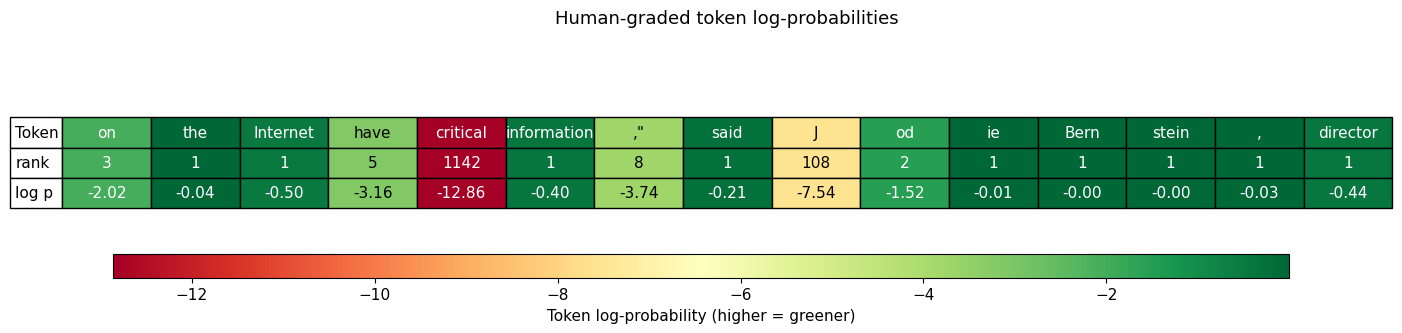

/var/folders/v3/_ft619t917q63j9n5v6t883h000_8v/T/ipykernel_54690/3762600754.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


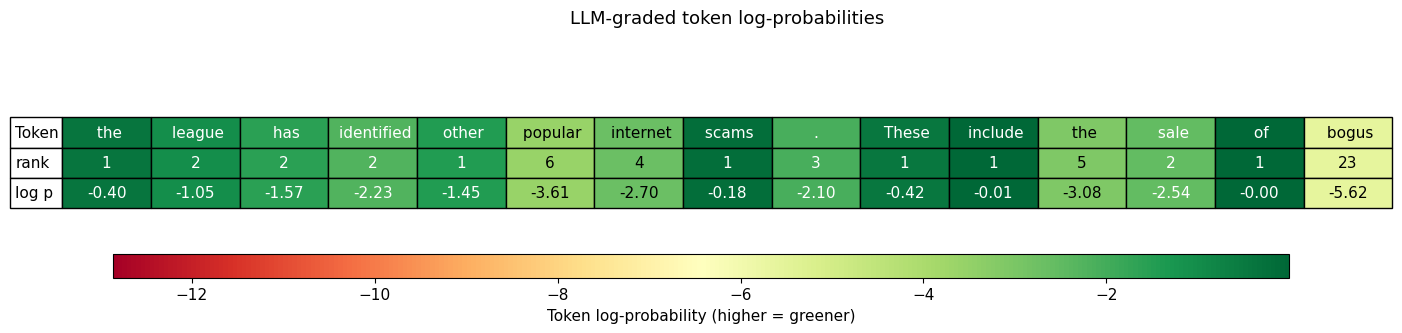

Saved:
   eda_outputs/figures/human_token_logprobs_15.png
   eda_outputs/figures/human_token_logprobs_15.pdf
   eda_outputs/figures/llm_token_logprobs_15.png
   eda_outputs/figures/llm_token_logprobs_15.pdf


In [69]:
# === Human figure ===
fig_h, ax_h = make_token_table_figure(
    df_human["Human Decoded Tokens"],
    df_human["Human Token Ranks"],
    df_human["Human Token Log Probs"],
    title="Human-graded token log-probabilities",
    lp_min=lp_min,
    lp_max=lp_max,
    font_size=FONT_SIZE,
)

human_png = os.path.join(output_dir, f"human_token_logprobs_{NUM_TOKENS}.png")
human_pdf = os.path.join(output_dir, f"human_token_logprobs_{NUM_TOKENS}.pdf")
fig_h.savefig(human_png, dpi=300, bbox_inches="tight")
fig_h.savefig(human_pdf, bbox_inches="tight")
plt.show()

# === LLM figure ===
fig_l, ax_l = make_token_table_figure(
    df_llm["LLM Decoded Tokens"],
    df_llm["LLM Token Ranks"],
    df_llm["LLM Token Log Probs"],
    title="LLM-graded token log-probabilities",
    lp_min=lp_min,
    lp_max=lp_max,
    font_size=FONT_SIZE,
)

llm_png = os.path.join(output_dir, f"llm_token_logprobs_{NUM_TOKENS}.png")
llm_pdf = os.path.join(output_dir, f"llm_token_logprobs_{NUM_TOKENS}.pdf")
fig_l.savefig(llm_png, dpi=300, bbox_inches="tight")
fig_l.savefig(llm_pdf, bbox_inches="tight")
plt.show()

print("Saved:")
print("  ", human_png)
print("  ", human_pdf)
print("  ", llm_png)
print("  ", llm_pdf)